In [1]:
import MGTomo.model as mgmodel
import numpy as np
import MGTomo.tomoprojection as mgproj
from MGTomo.utils import myexp, mylog, mydiv
import MGTomo.functions as fcts
from skimage.data import shepp_logan_phantom
from skimage.transform import resize
from MGTomo.optimize import armijo_linesearch

from MGTomo.gridop import P,R

import torch
from torch.func import grad

from torch.linalg import matrix_norm

import matplotlib.pyplot as plt 

In [2]:
max_levels = 1
maxIter = [5,5]

In [3]:
N = 63
# load image
x_orig = shepp_logan_phantom()
x_orig = resize(x_orig, (N,N), anti_aliasing = False)

x_torch = torch.tensor(x_orig, requires_grad = True)

In [4]:
model = mgmodel.astra_model(N,{'mode' : 'line', 'num_angles' : 50, 'level_decrease' : 1})
fine_dim = model.dim
A = [mgproj.TomoTorch(model.proj_factory(fine_dim))]
b = [A[0](x_torch)]
level = {int(np.sqrt(A[0].shape[1])): 0}

for i in range(1,max_levels+1):
    coarse_dim = model.reduce_dim(fine_dim)
    A.append(mgproj.TomoTorch(model.proj_factory(coarse_dim)))
    b.append(torch.from_numpy(model.reduce_rhs(b[-1].detach().numpy(), fine_dim, coarse_dim)))
    level.update({int(np.sqrt(A[i].shape[1])): i})
    fine_dim=coarse_dim

In [5]:
c0 = A[0].sumnorm()

In [6]:
fh = lambda x: fcts.kl_distance(x, A[0], b[0])

## Test relative L-smoothness of fh

In [7]:
def Dfhst(s,t):
    fhs = fh(s)
    fht = fh(t)
    fht.backward(retain_graph = True)
    grad_fh_t = t.grad.clone()
    #print(y0.grad)
    Dfhst = fhs - fht - torch.sum(grad_fh_t * (s-t))
    
    return Dfhst

def Klst(s,t):
    st = mydiv(s,t)
    KLst_zw = s* mylog(st) + s - t

    KLst = torch.sum( KLst_zw[t > 0.] ) + 0.5*torch.sum(st[t == 0.]**2)
    
    return KLst

In [8]:
for i in range(100):
    s = torch.rand(63, 63, requires_grad = True)
    t = torch.rand(63, 63, requires_grad = True)
    
    assert Dfhst(s,t) <= c0 * Klst(s,t)

In [9]:
tau0 = 0.5 * 1/c0

In [10]:
for i in range(100):
    z0 = torch.rand(63, 63, requires_grad = True)
    z1 = fcts.SMART(fh, z0, tau0)
    
    assert fh(z1) - fh(z0) <=0, fh(z1) - fh(z0)

In [11]:
z0 = torch.rand(63, 63, requires_grad = True)
for i in range(100):
    val = fcts.SMART(fh, z0, tau0)
    assert fh(val) - fh(z0) <= 0, fh(val) - fh(z0)
    z0 = val.clone().detach().requires_grad_(True)
    
    assert z0.grad is None
print(fh(z0))

tensor(28.1905, dtype=torch.float64, grad_fn=<AddBackward0>)


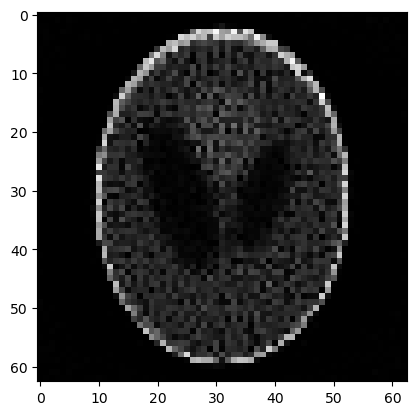

In [12]:
plt.imshow(z0.detach().numpy(), cmap = 'gray')

# Setup coarse model

In [13]:
y0 = torch.ones(N, N)*0.5
y0.requires_grad = True

In [14]:
x0 = R(y0)
x0.retain_grad()

x0 = x0.clone().detach().requires_grad_(True)
#print(x0)

fH = lambda x: fcts.kl_distance(x, A[1], b[1])

fhy0 = fh(y0)
fhy0.backward(retain_graph = True)

fHx0 = fH(x0)
fHx0.backward(retain_graph = True)

kappa = R(y0.grad) - x0.grad

In [15]:
def psi(x):
    val = fH(x) + torch.sum(kappa * (x-x0))
    return val

In [16]:
y0.grad.zero_()

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

## Test coarse model psi and coarse function fH properties

In [17]:
psi(x0) - fH(x0)

tensor(0., dtype=torch.float64, grad_fn=<SubBackward0>)

In [18]:
#y0.grad

In [19]:
def DfHuv(u,v):
    fHu = fH(u)
    fHv = fH(v)
    fHv.backward(retain_graph = True)
    grad_fH_v = v.grad.clone()
    #print(y0.grad)
    DfHuv = fHu - fHv - torch.sum(grad_fH_v * (u-v))
    return DfHuv

def Dpsiuv(u,v):
    psiu = psi(u)
    psiv = psi(v)
    #print(y0.grad)
    psiv.backward()
    #print(y0.grad)
    Dpsiuv = psiu - psiv - torch.sum(v.grad *(u-v))
    
    return Dpsiuv

In [20]:
c1 = A[1].sumnorm()

In [21]:
c1

tensor(56.0952, dtype=torch.float64)

In [22]:
for i in range(100):
    u = torch.rand(31,31, requires_grad = True)
    v = torch.rand(31,31, requires_grad = True)
    
    Dpsi = Dpsiuv(u,v)
    v.grad.zero_()
    DfH = DfHuv(u,v)
    v.grad.zero_()
    assert (Dpsi - DfH).abs() <= 0.2, Dpsi - DfH
    
    Kl = Klst(u,v)
    
    assert Dpsi - c1*Kl <=0.1, Dpsi - c1*Kl

In [23]:
y0.grad

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

## Test psi and SMART

In [24]:
tau1 = 0.5 * 1/c1

In [25]:
for i in range(100):
    z0 = torch.rand(31, 31, requires_grad = True)
    z1 = fcts.SMART(psi, z0, tau1)
    
    assert psi(z1) - psi(z0) <=0, psi(z1) - psi(z0)

In [26]:
z0 = torch.rand(31, 31, requires_grad = True)
for i in range(100):
    val = fcts.SMART(psi, z0, tau1)
    assert psi(val) - psi(z0) <= 0, psi(val) - psi(z0)
    z0 = val.clone().detach().requires_grad_(True)
    assert z0.min() >= 0
    assert z0.grad is None

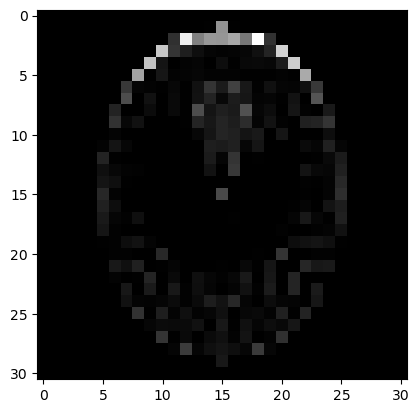

In [27]:
plt.imshow(z0.detach().numpy(), cmap = 'gray')

In [28]:
y0.grad

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

In [29]:
def coarse_condition(y, grad_y, kappa, y_last = None):
    gcond = (matrix_norm(R(grad_y), ord = 1) >= kappa * matrix_norm(grad_y, ord = 1))
    if y_last is not None:
        y_diff_norm = matrix_norm(y_last - y, ord = 1)
        return gcond and (y_diff_norm >= kappa)
    else:
        return gcond

## MLO with an explicit implementation of psi

In [30]:
def MLO(fh, y, last_pts: list, l=0, kappa = 0.5):
    x = R(y).detach().requires_grad_(True)
    y0, x0 = y, x.clone().detach().requires_grad_(True)
    
    fhy0 = fh(y0)
    fhy0.backward(retain_graph = True)
    grad_fhy0 = y0.grad.clone()
    y0.grad.zero_()
    
    #print('coarse correction at l = ', l)
    if coarse_condition(y, grad_fhy0, kappa, last_pts[l]):
        print(l, ' : coarse correction activated')
        
        last_pts[l] = y0.clone().detach()
    
        fH = lambda x: fcts.kl_distance(x, A[l+1], b[l+1])
        fHx0 = fH(x0)
        fHx0.backward(retain_graph = True)
        grad_fHx0 = x0.grad.clone()
        x0.grad.zero_()

        kappa = R(grad_fhy0) - grad_fHx0

        psi = lambda x: fH(x) + torch.sum(kappa * (x-x0))

        for i in range(maxIter[l]):
            x.retain_grad()
            val = fcts.SMART(psi, x, tau[l+1])
            x = val.clone().detach().requires_grad_(True)
            
        if l < max_levels-1:
            x, last_pts, _ = MLO(psi, x, last_pts, l+1)
            #print('x', x)
            #print('xlast', xlast)

        assert psi(x) < psi(x0), 'psi(x) < psi(x0) = fH(x0) does not hold'
    else: 
        print(l, ' : coarse correction not activated')
    
    d = P(x-x0)
    z, a = armijo_linesearch(fh, y0, d)
    
    assert z.min() >= 0
    
    for i in range(maxIter[l]):
        z.retain_grad()
        zval = fcts.SMART(fh, z, tau[l])
        y0.grad.zero_()
        z = zval.clone().detach().requires_grad_(True)
    return z, last_pts, a

In [31]:
tau = [tau0, tau1]

In [32]:
for i in range(100):
    z0 = torch.rand(63, 63, requires_grad = True)
    z1, ylast, _ = MLO(fh, z0)
    
    assert fh(z1) - fh(z0) <=0, fh(z1) - fh(z0)

0  : coarse correction activated
0  : coarse correction activated
0  : coarse correction activated
0  : coarse correction activated
0  : coarse correction activated
0  : coarse correction activated
0  : coarse correction activated
0  : coarse correction activated
0  : coarse correction activated
0  : coarse correction activated
0  : coarse correction activated
0  : coarse correction activated
0  : coarse correction activated
0  : coarse correction activated
0  : coarse correction activated
0  : coarse correction activated
0  : coarse correction activated
0  : coarse correction activated
0  : coarse correction activated
0  : coarse correction activated
0  : coarse correction activated
0  : coarse correction activated
0  : coarse correction activated
0  : coarse correction activated
0  : coarse correction activated
0  : coarse correction activated
0  : coarse correction activated
0  : coarse correction activated
0  : coarse correction activated
0  : coarse correction activated
0  : coars

In [33]:
a = []
z0 = torch.rand(63, 63, requires_grad = True)
ylast = None
print(fh(z0))
for i in range(100):
    val, ylast, alpha = MLO(fh, z0, y_last=ylast)
    assert fh(val) - fh(z0) <= 0, fh(val) - fh(z0)
    z0 = val.clone().detach().requires_grad_(True)
    assert z0.min() >= 0
    assert z0.grad is None
    a.append(alpha)
print(fh(z0))

tensor(168058.6712, dtype=torch.float64, grad_fn=<AddBackward0>)
0  : coarse correction activated
0  : coarse correction activated
0  : coarse correction activated
0  : coarse correction activated
0  : coarse correction activated
0  : coarse correction activated
0  : coarse correction activated
0  : coarse correction activated
0  : coarse correction activated
0  : coarse correction activated
0  : coarse correction not activated
0  : coarse correction activated
0  : coarse correction not activated
0  : coarse correction activated
0  : coarse correction not activated
0  : coarse correction activated
0  : coarse correction not activated
0  : coarse correction not activated
0  : coarse correction activated
0  : coarse correction not activated
0  : coarse correction not activated
0  : coarse correction activated
0  : coarse correction not activated
0  : coarse correction not activated
0  : coarse correction not activated
0  : coarse correction activated
0  : coarse correction not activated


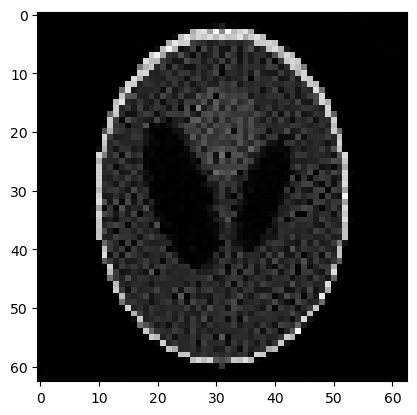

In [34]:
plt.imshow(z0.detach().numpy(), cmap = 'gray')